# **ADNI images classification**

In this project work we use the ADNI (Alzheimer's Disease Neuroimaging Initiative) dataset consists of two different images format: 3D PET and RM images. It contains clinical, neuroimaging, and biomarker data from individuals with normal cognition, mild cognitive impairment (MCI), and Alzheimer's disease (AD).

We focuse our analysis only on the AD (107 RM images) and HC (346 RM images) images classes identify respectively sick patients and the healty ones in order to perform the classification task in two different ways:
- Classification of patients (sick/healty) using a Random Forest algorithm trained on features extracted by PyRadiomics and re-trained on the 5 most informative features selected through RFE (Recursive Feature Elimination)
- Classification based on a Convolutional neural Networks

(link to Google Drive repository to access the projet: https://drive.google.com/drive/folders/1fyHbiuXpiISrjViH2GSm8zlgkzbrybLe?usp=sharing)


Install pyradiomics library and load packages

In [ ]:
!pip install pyradiomics

In [ ]:
import matplotlib.pyplot as plt # plotting
import pandas as pd # DB
import radiomics
from radiomics import featureextractor
import nibabel as nib
import os
import glob
import numpy as np
import csv
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
import seaborn as sns
from sklearn.metrics import confusion_matrix
import shutil
from shutil import copyfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy import ndimage
from tqdm import tqdm
import cv2
from sklearn.metrics import classification_report
import sys
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, f1_score, accuracy_score
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **EXAMPLE: Read and display a patient**
We take a look on one of AD and HC patient.

The files are read using nib.load(fname), which return a structure with all relevant files information.

Read a T1ce file and plot a figure with 3 central planes in order to see the 3 different brain slices.

In [ ]:
head = nib.load('/content/drive/MyDrive/Med_Imag- Project/ADNI_DB/AD/MR/w003_S_6833.nii.gz') 

In [ ]:
dir(head)

['ImageArrayProxy',
 'ImageSlicer',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_affine',
 '_affine2header',
 '_compressed_suffixes',
 '_data',
 '_data_cache',
 '_dataobj',
 '_fdata_cache',
 '_get_fileholders',
 '_header',
 '_load_cache',
 '_meta_sniff_len',
 '_sniff_meta_for',
 'affine',
 'as_reoriented',
 'dataobj',
 'extra',
 'file_map',
 'files_types',
 'filespec_to_file_map',
 'filespec_to_files',
 'from_bytes',
 'from_file_map',
 'from_filename',
 'from_files',
 'from_image',
 'get_affine',
 'get_data',
 'get_data_dtype',
 'get_fdata',
 'get_filename',
 'get_header',
 'get_qform',
 'get_sform',
 'get_shape',
 'header',
 'header_class',
 'in_m

In [ ]:
t1ce = head.get_fdata(dtype=np.float32)

(-0.5, 126.5, 104.5, -0.5)

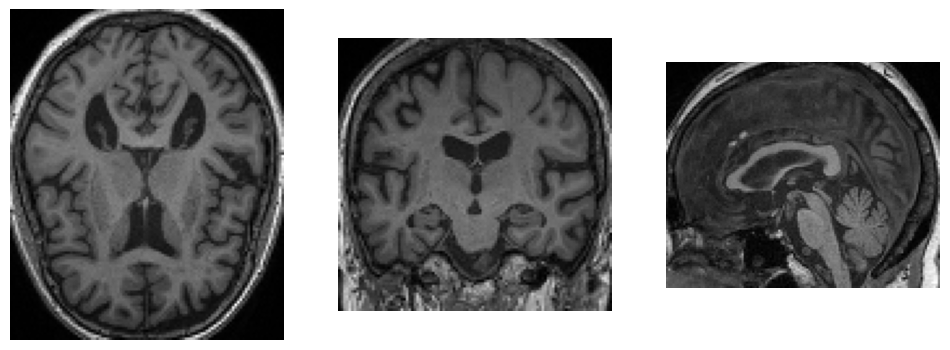

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(131)
imDim = t1ce.shape
plt.imshow(t1ce[:,:,imDim[2]//2].T,cmap='gray') #3 dim (slice a fette)
plt.axis('off')
plt.subplot(132)
imDim = t1ce.shape
plt.imshow(np.flip(t1ce[:,imDim[1]//2,:]).T,cmap='gray') # 2 dim (slice frontale)
plt.axis('off')
plt.subplot(133)
imDim = t1ce.shape
plt.imshow(np.flip(t1ce[imDim[0]//2,:,:].T),cmap='gray') #1 dim (slcie laterale)
plt.axis('off')

In [ ]:
head = nib.load('/content/drive/MyDrive/Med_Imag- Project/ADNI_DB/HC/MR_out/wm002_S_0413.nii.gz') 

In [ ]:
t1ce = head.get_fdata(dtype=np.float32)

(-0.5, 126.5, 104.5, -0.5)

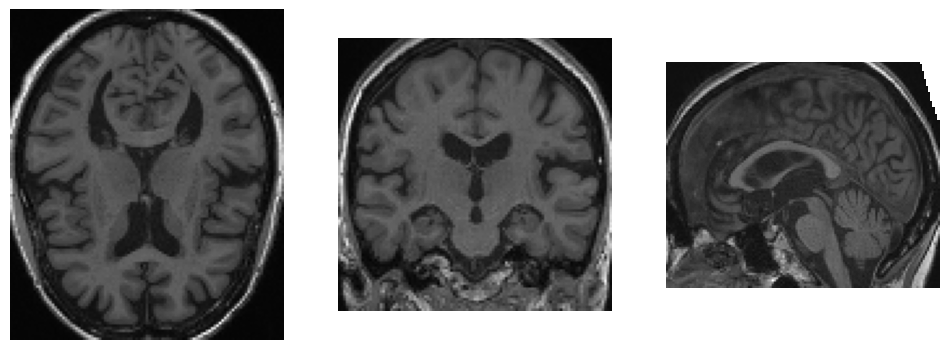

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(131)
imDim = t1ce.shape
plt.imshow(t1ce[:,:,imDim[2]//2].T,cmap='gray')
plt.axis('off')
plt.subplot(132)
imDim = t1ce.shape
plt.imshow(np.flip(t1ce[:,imDim[1]//2,:]).T,cmap='gray')
plt.axis('off')
plt.subplot(133)
imDim = t1ce.shape
plt.imshow(np.flip(t1ce[imDim[0]//2,:,:].T),cmap='gray')
plt.axis('off')

## Put a mask

Now read the mask and overlaid it to the previous images AD and HC in order to highlight the correct area the algorithm will elaborate and be trained on to classify ill and healty patients
testo in grassetto

In [ ]:
headMask = nib.load('/content/drive/MyDrive/Med_Imag- Project/ADNI_DB/rmask_ICV.nii')

In [ ]:
maskImm = headMask.get_fdata(dtype=np.float32)

 To automatically center the image we compute the center of brain area, which is label 1 and 4

In [ ]:
maskV = (maskImm == 1) | (maskImm==4)
maskDim = maskImm.shape
maskSum = np.sum(maskV )
xCom = int(np.sum((maskV)*np.arange(maskDim[0]).reshape((maskDim[0],1,1)))/maskSum)
yCom = int(np.sum((maskV)*np.arange(maskDim[1]).reshape((1,maskDim[1],1)))/maskSum)
zCom = int(np.sum((maskV)*np.arange(maskDim[2]).reshape((1,1,maskDim[2])))/maskSum)

In [ ]:
xCom,yCom,zCom

(51, 60, 53)

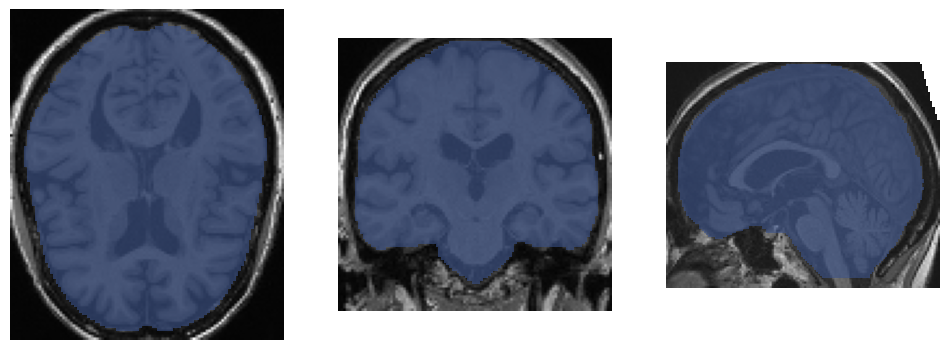

In [ ]:

maskImm[maskImm<0.5]=np.nan
plt.figure(figsize=(12,8))
plt.subplot(131)
imDim = t1ce.shape
plt.imshow(t1ce[:,:,zCom].T,cmap='gray')
plt.imshow(maskImm[:,:,zCom].T,vmin=0,vmax=4,alpha=0.6)
plt.axis('off')
plt.subplot(132)
imDim = t1ce.shape
plt.imshow(np.flip(t1ce[:,yCom,:]).T,cmap='gray')
plt.imshow(np.flip(maskImm[:,yCom,:]).T,vmin=0,vmax=4,alpha=0.6)
plt.axis('off')
plt.subplot(133)
imDim = t1ce.shape
plt.imshow(np.flip(t1ce[xCom,:,:].T),cmap='gray')
plt.imshow(np.flip(maskImm[xCom,:,:].T),vmin=0,vmax=4,alpha=0.6)
_=plt.axis('off')

#**1. RANDOM FOREST CLASSIFICATION**




## Images with mask for both the classes and features extraction

Do a list of the files and modify them by overlapping a mask on healthy subjects and on the ill ones.
Extract images with the default setting the radiomic features on the original images.
Save the features names and the extracted features list as arrays and combine them in order to have information about the name of each features for healty and ill patients.

In [ ]:
Health_list = glob.glob('/content/drive/MyDrive/Med_Imag- Project/ADNI_DB/HC/MR_out/*') 
print(len(Health_list))
Ill_list = glob.glob('/content/drive/MyDrive/Med_Imag- Project/ADNI_DB/AD/MR/*') 
print(len(Ill_list))

346
106


In [ ]:
ext = featureextractor.RadiomicsFeatureExtractor()

INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}


In [ ]:
ext.settings

{'minimumROIDimensions': 2,
 'minimumROISize': None,
 'normalize': False,
 'normalizeScale': 1,
 'removeOutliers': None,
 'resampledPixelSpacing': None,
 'interpolator': 'sitkBSpline',
 'preCrop': False,
 'padDistance': 5,
 'distances': [1],
 'force2D': False,
 'force2Ddimension': 0,
 'resegmentRange': None,
 'label': 1,
 'additionalInfo': True}

In [ ]:
fv = ext.execute(Health_list[0],'/content/drive/MyDrive/Med_Imag- Project/ADNI_DB/rmask_ICV.nii')

INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


In [ ]:
feature_names = list(sorted(filter(lambda k : k.startswith("original_"), fv)))

In [ ]:
Health_List_Feat = np.zeros((len(feature_names),len(Health_list)))
for patIdx, file in enumerate(Health_list):
  if file.endswith('.gz'): 
            healthFile = os.path.join(file)
            maskFile = '/content/drive/MyDrive/Med_Imag- Project/ADNI_DB/rmask_ICV.nii'
            fv = ext.execute(healthFile, maskFile)
            for featIdx, feat in enumerate(feature_names):
                Health_List_Feat[featIdx, patIdx] = fv[feat]

INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor

In [ ]:
with open('health_features.npy', 'wb') as f:
    np.save(f, np.array(Health_List_Feat))

In [ ]:
with open('names_hl.npy', 'wb') as f:
    np.save(f, np.array(Health_list))

In [ ]:
df = pd.DataFrame()
for i in range(107):
  df[f'feat_{i}'] = Health_List_Feat[i,:]
df['img_name'] = Health_list

df.to_csv('health_features.csv')

In [ ]:
fv2 = ext.execute(Ill_list[0],'/content/drive/MyDrive/Med_Imag- Project/ADNI_DB/rmask_ICV.nii')

In [ ]:
feature_names = list(sorted(filter(lambda k : k.startswith("original_"), fv2)))

In [ ]:
Ill_List_Feat = np.zeros((len(feature_names),len(Ill_list)))
for patIdx, file in enumerate(Ill_list):
  if file.endswith('.gz'): 
            illFile = os.path.join(file)
            maskFile = '/content/drive/MyDrive/Med_Imag- Project/ADNI_DB/rmask_ICV.nii'
            fv2 = ext.execute(illFile, maskFile)
            for featIdx, feat in enumerate(feature_names):
                Ill_List_Feat[featIdx, patIdx] = fv2[feat]

INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor

In [ ]:
with open('ill_features.npy', 'wb') as f:
    np.save(f, np.array(Ill_List_Feat))

In [ ]:
with open('names_il.npy', 'wb') as f:
    np.save(f, np.array(Ill_list))

In [ ]:
df = pd.DataFrame()
for i in range(107):
  df[f'feat_{i}'] = Ill_List_Feat[i,:]
df['img_name'] = Ill_list

df.to_csv('ill_features.csv')

## Prepare and split the data
Load the .csv files contain the combined features names and the extracted features of both of the AD and HC classes.

Delate the "Unnamed: 0" column generated during the extraction phase and the "img_name" column in order to prepare the data and to the split.

Split the data into: 60% train, 20% validation and 20% test set in a fixed way in order to select the same images for the different tasks execution(*Classification through RF* and *Classification through CNN*).


In [ ]:
file_path = "/content/drive/MyDrive/Med_Imag- Project/health_features.csv"
data_hf = pd.read_csv(file_path)


In [ ]:
data_hf.drop(columns=['Unnamed: 0'], inplace=True)


In [ ]:
file_path = "/content/drive/MyDrive/Med_Imag- Project/ill_features.csv"
data_if = pd.read_csv(file_path)

In [ ]:
data_if.drop(columns=['Unnamed: 0'], inplace=True)


In [ ]:
data_hf.drop(columns=['img_name'], inplace=True)
data_if.drop(columns=['img_name'], inplace=True)

sani_train = data_hf[0:int(len(data_hf)*0.6)]
sani_valid = data_hf[int(len(data_hf)*0.6):int(len(data_hf)*0.8)]
sani_test = data_hf[int(len(data_hf)*0.8):int(len(data_hf)*1)]

malati_train = data_if[0:int(len(data_if)*0.6)]
malati_valid = data_if[int(len(data_if)*0.6):int(len(data_if)*0.8)]
malati_test = data_if[int(len(data_if)*0.8):int(len(data_if)*1)]

Classify AD and HC patients

Combine the prepared data to set: X_train, y_train, X_test, y_test, X_valid, y_valid.

Train a *Random Forest classificator* and test the performance on the validation and test dataset.

We notice high accuracy on the train, but also on the validation and test set.

In [ ]:
X_train = pd.concat([sani_train, malati_train])
y_train = np.concatenate([np.zeros(len(sani_train)), np.ones(len(malati_train))])

X_test = pd.concat([sani_test, malati_test])
y_test = np.concatenate([np.zeros(len(sani_test)), np.ones(len(malati_test))])

X_valid = pd.concat([sani_valid, malati_valid])
y_valid = np.concatenate([np.zeros(len(sani_valid)), np.ones(len(malati_valid))])

In [ ]:
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)


In [ ]:
clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=5, random_state=42)

In [ ]:
clf.score(X_train, y_train)

1.0

In [ ]:
clf.score(X_valid,y_valid)

0.9111111111111111

In [ ]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9565217391304348


## Comparing confusion matrix results on validation and test set
From the confusion matrix built by considering the predictions made on the validation set, we notice that all the 69 actually negative featureas are correctly classified as negative (*True Negative, TN*) by the *Random Forest* algorithm. Otherwise, it misclassifies 8 real positive features as negative (*False Negative, FN*) but correctly classifies as positive the other 13 features (*True Positive, TP*) of the real 21 positive instances.

In [ ]:
y_pred = clf.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred)

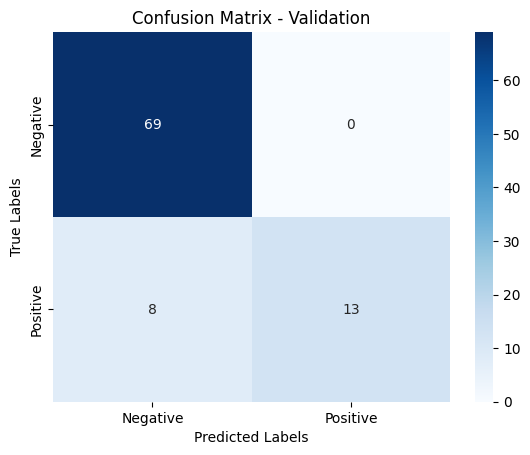

In [ ]:
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix - Validation")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

Precision: 1.0
Recall: 0.6190476190476191
F1 score: 0.7647058823529412


By observing the confusion matrix of the predicted values on the test set, we find out that the algorithm misclassifies 1 instance as positive (*False Positive, FP*) of the overall true negative observations. Moreover, it wrongly classifies 3 features as negative (*False Negative, FN*) of the 21 real positive ones.

In [ ]:
y_pred1 = clf.predict(X_test)
cm1 = confusion_matrix(y_test, y_pred1)

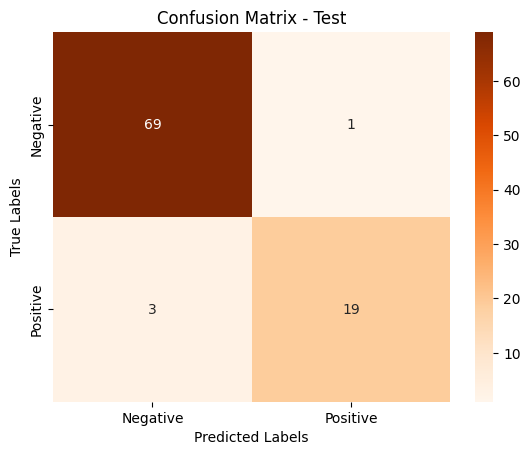

In [ ]:
sns.heatmap(cm1, annot=True, cmap="Oranges", fmt="d", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix - Test")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
precision = precision_score(y_test, y_pred1)
recall = recall_score(y_test, y_pred1)
f1 = f1_score(y_test, y_pred1)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

Precision: 0.95
Recall: 0.8636363636363636
F1 score: 0.9047619047619048


# **2. RFE**

Use *RFE* to select only the 5 most important features and then compare the *RF classifier* performance results.

In [ ]:
rfe = RFE(estimator=clf, n_features_to_select=5, step=0.2)
rfe.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(max_depth=5, random_state=42),
    n_features_to_select=5, step=0.2)

Take a look on the selected features

In [ ]:
selected_features = X_train.columns[rfe.support_]
print(selected_features)


Index(['feat_10', 'feat_14', 'feat_32', 'feat_55', 'feat_89'], dtype='object')


We can observe that the accuracy of the model performance on the validation set remains the same (0.91). However, the accuracy of the model performance on the test set seems to increase (0.99). It can be explained due to the presence of the most informative features found by RFE.

In [ ]:
redFeatNames = []
for i in range(rfe.ranking_.shape[0]):
    if rfe.ranking_[i] == 1:
        redFeatNames.append(feature_names[i])
        print(feature_names[i])


original_firstorder_Minimum
original_firstorder_Skewness
original_glcm_Imc2
original_gldm_SmallDependenceLowGrayLevelEmphasis
original_ngtdm_Coarseness


In [ ]:
score2 = rfe.score(X_valid, y_valid)

print("Selected features:", X_train.columns[rfe.support_])
print("Score of selected features:", score2)

Selected features: Index(['feat_10', 'feat_14', 'feat_32', 'feat_55', 'feat_89'], dtype='object')
Score of selected features: 0.9111111111111111


In [ ]:
score = rfe.score(X_test, y_test)

print("Selected features:", X_train.columns[rfe.support_])
print("Score of selected features:", score)

Selected features: Index(['feat_10', 'feat_14', 'feat_32', 'feat_55', 'feat_89'], dtype='object')
Score of selected features: 0.9891304347826086


Confusion matrix results

The confusion matrix below shows the predicted values of the validation set. The classifier identifies all the actual negative features and misclassifies only 8 features as negative of the overall 21 positive ones.

In [ ]:
y_pred2 = rfe.predict(X_valid)
cm2 = confusion_matrix(y_valid, y_pred2)

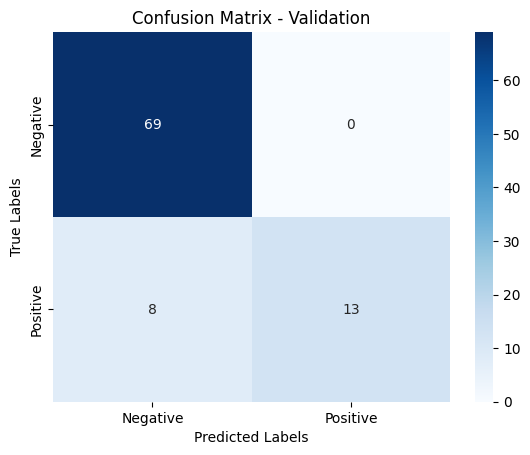

In [ ]:
sns.heatmap(cm2, annot=True, cmap="Blues", fmt="d", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix - Validation")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
precision = precision_score(y_valid, y_pred2)
recall = recall_score(y_valid, y_pred2)
f1 = f1_score(y_valid, y_pred2)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

Precision: 1.0
Recall: 0.6190476190476191
F1 score: 0.7647058823529412


In [ ]:
y_pred3 = rfe.predict(X_test)
cm3 = confusion_matrix(y_test, y_pred3)

The predicted values on the test set are all correctly classified by the algorithm for the negative label. It misclassifies only 1 instance as negative of the 22 true positive features.

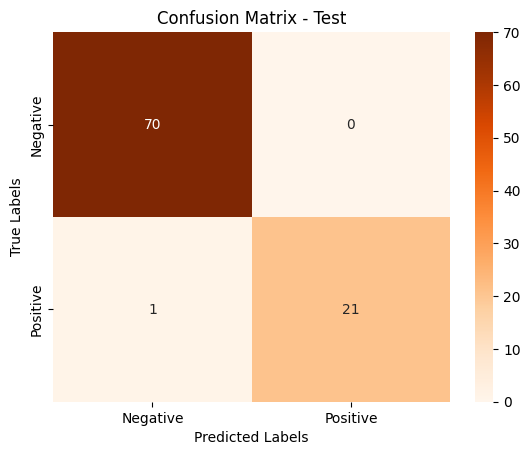

In [ ]:
sns.heatmap(cm3, annot=True, cmap="Oranges", fmt="d", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix - Test")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
precision = precision_score(y_test, y_pred3)
recall = recall_score(y_test, y_pred3)
f1 = f1_score(y_test, y_pred3)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

Precision: 1.0
Recall: 0.9545454545454546
F1 score: 0.9767441860465117


# **3. 3D Convolutional Neural Network**

In [ ]:
path_adni = "/content/drive/MyDrive/Med_Imag- Project/ADNI_DB"

## Import files

In [ ]:
os.mkdir("original")
os.mkdir("original/HC")
os.mkdir("original/AD")

In [ ]:
for i in os.listdir(f"{path_adni}/HC/MR_out"):
  copyfile(f"{path_adni}/HC/MR_out/{i}", f"original/HC/{i}")

In [ ]:
for i in os.listdir(f"{path_adni}/AD/MR"):
  copyfile(f"{path_adni}/AD/MR/{i}", f"original/AD/{i}")

## Define Data Loader

In [ ]:
# Define useful operations: Read, Resize
def read_nifti_file(filepath):
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    return scan

def resize_volume(img):
    desired_depth = 64
    desired_width = 64
    desired_height = 64

    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]

    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height

    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def process_scan(path):
    volume = read_nifti_file(path)
    volume = resize_volume(volume)
    return volume

In [ ]:
# Read paths
normal_scan_paths = [
    os.path.join(os.getcwd(), "original/HC", x)
    for x in os.listdir("original/HC")
]

abnormal_scan_paths = [
    os.path.join(os.getcwd(), "original/AD", x)
    for x in os.listdir("original/AD")
]

print("normal: " + str(len(normal_scan_paths)))
print("abnormal: " + str(len(abnormal_scan_paths)))

normal: 346
abnormal: 106


In [ ]:
# Read and process files, and assign them to train and test set
abnormal_scans = np.array([process_scan(path) for path in tqdm(abnormal_scan_paths)])
normal_scans = np.array([process_scan(path) for path in tqdm(normal_scan_paths)])

abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

x_train = np.concatenate((abnormal_scans[:int(len(abnormal_scans)*0.7)], normal_scans[:int(len(normal_scans)*0.7)]), axis=0)
y_train = np.concatenate((abnormal_labels[:int(len(abnormal_scans)*0.7)], normal_labels[:int(len(normal_scans)*0.7)]), axis=0)
x_val = np.concatenate((abnormal_scans[int(len(abnormal_scans)*0.7):], normal_scans[int(len(normal_scans)*0.7):]), axis=0)
y_val = np.concatenate((abnormal_labels[int(len(abnormal_scans)*0.7):], normal_labels[int(len(normal_scans)*0.7):]), axis=0)


100%|██████████| 346/346 [00:37<00:00,  9.18it/s]


In [ ]:
def train_preprocessing(volume, label):
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [ ]:
# Define data loaders
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

## Network definition and training

In [ ]:
def get_model(width=64, height=64, depth=64):
    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.GlobalAveragePooling3D()(x)

    x = layers.Dense(units=128, activation="relu")(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model
model = get_model(width=64, height=64, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 64, 1)]   0         
                                                                 
 conv3d_6 (Conv3D)           (None, 62, 62, 62, 32)    896       
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 31, 31, 31, 32)   0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 29, 29, 29, 64)    55360     
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 14, 14, 14, 64)   0         
 3D)                                                             
                                                                 
 global_average_pooling3d_3   (None, 64)               0     

In [ ]:
# Compile model
lr = 0.01

model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr),
    metrics=["accuracy"],
)

# Define callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10)

# Train the model, doing validation at the end of each epoch
epochs = 20
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

In [ ]:
label = np.array([])
pred = np.array([])
for x, y in val_dataset:
  label = np.concatenate([label, y])
  pred = np.concatenate([pred, model.predict(x, verbose=0)>0.5])

cf_matrix = confusion_matrix(label, pred)
print(classification_report(label, pred))


In [ ]:
cf_matrix = confusion_matrix(label, pred)
print(classification_report(label, pred))

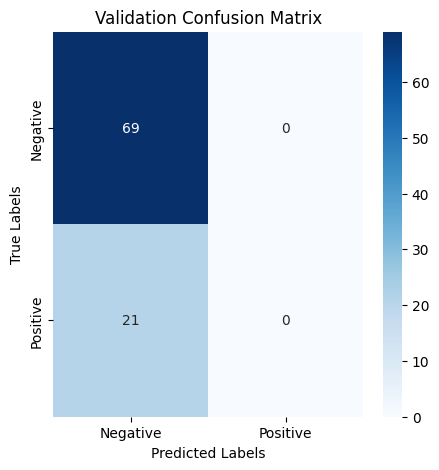

In [ ]:
plt.rcParams['figure.figsize'] = [5,5] # width, height
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=["Negative","Positive"], yticklabels=["Negative","Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Validation Confusion Matrix")
plt.show()

# **4. 2D Convolutional Neural Network**

## Data Preparation

In [ ]:
# Create empty folder in which to split the data
os.mkdir("train")
os.mkdir("train/AD")
os.mkdir("train/HC")

os.mkdir("val")
os.mkdir("val/AD")
os.mkdir("val/HC")

os.mkdir("test")
os.mkdir("test/AD")
os.mkdir("test/HC")

In [ ]:
# Assignment of each slice of each MR to a specific folder
# All the slices of a MR are assignet to the same partition

for j,i in enumerate(os.listdir(f"{path_adni}/HC/MR_out")):
  if j < 346*0.6:
    path='train'
  elif j < 346*0.8:
    path='val'
  else:
    path='test'

  head = nib.load(f"{path_adni}/HC/MR_out/{i}")
  original_img = head.get_fdata(dtype=np.float32)
  for sl in range(105):
    img = original_img[:,:,sl]
    cv2.imwrite(f"{path}/HC/{i[:-7]}____{sl}.png", img)

for j,i in enumerate(os.listdir(f"{path_adni}/AD/MR")):
  if j < 106*0.6 :
    path='train'
  elif j < 106*0.8:
    path='val'
  else:
    path='test'

  head = nib.load(f"{path_adni}/AD/MR/{i}")
  original_img = head.get_fdata(dtype=np.float32)
  for sl in range(105):
    img = original_img[:,:,sl]
    cv2.imwrite(f"{path}/AD/{i[:-7]}____{sl}.png", img)


In [ ]:
print(f"train - AD - {len(os.listdir('train/AD'))}")
print(f"train - HC - {len(os.listdir('train/HC'))}")
print(f"valid - AD - {len(os.listdir('val/AD'))}")
print(f"valid - HC - {len(os.listdir('val/HC'))}")
print(f"test - AD - {len(os.listdir('test/AD'))}")
print(f"test - HC - {len(os.listdir('test/HC'))}")

train - AD - 6720
train - HC - 21840
valid - AD - 2205
valid - HC - 7245
test - AD - 2205
test - HC - 7245


In [ ]:
# Data loaders

train_path='train'
train_dataset = keras.preprocessing.image_dataset_from_directory(train_path,
                                                            image_size=(128,128),
                                                            color_mode='grayscale',
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            shuffle=True,
                                                            interpolation='bilinear',
                                                            seed=1)
val_path='val'
val_dataset = keras.preprocessing.image_dataset_from_directory(val_path,
                                                            image_size=(128,128),
                                                            color_mode='grayscale',
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            shuffle=True,
                                                            interpolation='bilinear',
                                                            seed=1)


Found 28560 files belonging to 2 classes.
Found 9450 files belonging to 2 classes.


## Training 

In [ ]:
num_classes = 2

# Define the network
inputs = keras.Input((128,128,1))

x = inputs
x = keras.layers.Conv2D(32, 3, padding="same")(x) 
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) 

x = keras.layers.Conv2D(64, 3, padding="same")(x) 
x = keras.layers.Activation("relu")(x)


x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x) 
net = keras.Model(inputs, outputs)


# Compile the model
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

# Fit the model
history = net.fit(train_dataset,
          epochs=50,
          validation_data=val_dataset);

Epoch 1/50
1037/1037 [==============================] - 25s 23ms/step - loss: 1.4225 - accuracy: 0.7172 - val_loss: 0.5587 - val_accuracy: 0.7686
Epoch 2/50
1037/1037 [==============================] - 27s 26ms/step - loss: 0.4702 - accuracy: 0.7864 - val_loss: 0.4987 - val_accuracy: 0.7898
Epoch 3/50
1037/1037 [==============================] - 27s 26ms/step - loss: 0.3933 - accuracy: 0.8281 - val_loss: 0.4445 - val_accuracy: 0.8268
Epoch 4/50
1037/1037 [==============================] - 23s 22ms/step - loss: 0.3355 - accuracy: 0.8610 - val_loss: 0.4302 - val_accuracy: 0.8502
Epoch 5/50
1037/1037 [==============================] - 23s 23ms/step - loss: 0.2994 - accuracy: 0.8794 - val_loss: 0.5368 - val_accuracy: 0.8292
Epoch 6/50
1037/1037 [==============================] - 22s 21ms/step - loss: 0.2706 - accuracy: 0.8927 - val_loss: 0.4172 - val_accuracy: 0.8504
Epoch 7/50
1037/1037 [==============================] - 24s 23ms/step - loss: 0.2454 - accuracy: 0.9048 - val_loss: 0.4551 -

In [ ]:
net.save('model.h5')

In [ ]:
labels = np.array([])
pred = np.array([])
for x, y in val_dataset:
  labels = np.concatenate([labels, np.argmin(y.numpy(), axis=-1)])
  pred = np.concatenate([pred, np.argmin(net.predict(x, verbose=0), axis=-1)])

cf_matrix = confusion_matrix(labels, pred)
print(classification_report(labels, pred))



              precision    recall  f1-score   support

         0.0       0.94      0.93      0.93      7245
         1.0       0.78      0.79      0.78      2205

    accuracy                           0.90      9450
   macro avg       0.86      0.86      0.86      9450
weighted avg       0.90      0.90      0.90      9450



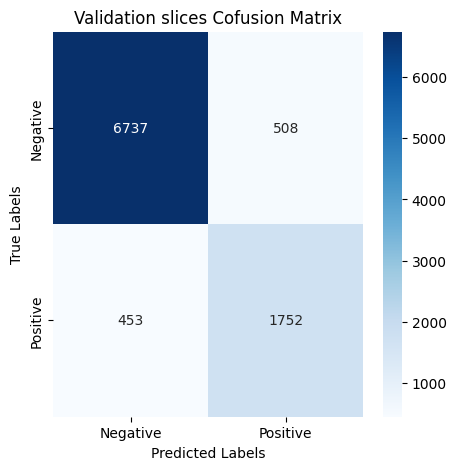

In [ ]:
plt.rcParams['figure.figsize'] = [5,5] # width, height
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=["Negative","Positive"], yticklabels=["Negative","Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Validation slices Cofusion Matrix")
plt.show()

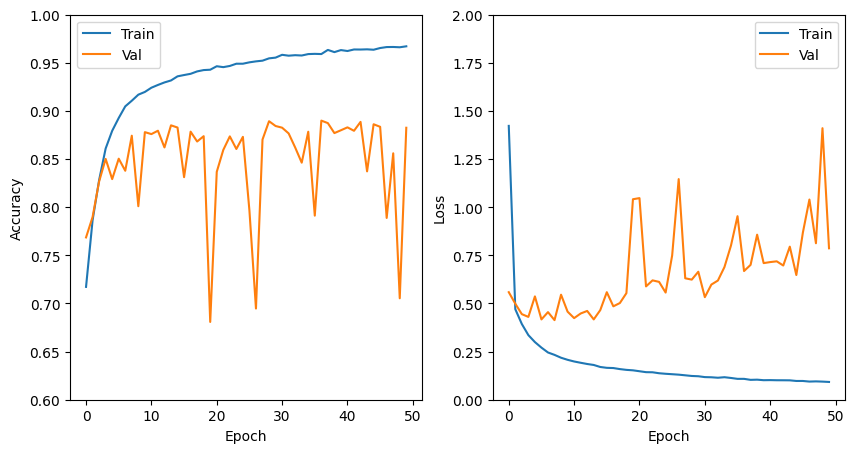

In [ ]:
plt.rcParams['figure.figsize'] = [10,5] 

#plot the accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.6, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Val'])


#plot the loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0, 2])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Val'])

plt.show()

## Results on Validation Set

In [ ]:
# Predictin on the whole validation set
val_ad = list(set([i.split('___')[0] for i in os.listdir('val/AD')]))
val_hc = list(set([i.split('___')[0] for i in os.listdir('val/HC')]))

pred = []
label = []
for i in tqdm(val_ad):
  current_pred=[]
  for j in range(105):
    img = cv2.imread(f'val/AD/{i}____{j}.png',0)
    f=np.expand_dims(np.expand_dims(cv2.resize(img,(128,128), interpolation=cv2.INTER_LINEAR), 0),3)
    current_pred.append(np.argmin(net.predict(f, verbose=0)))

  pred.append(sum(current_pred)/len(current_pred))

  label.append(1)

for i in tqdm(val_hc):
  current_pred=[]
  for j in range(105):
    img = cv2.imread(f'val/HC/{i}____{j}.png',0)
    f=np.expand_dims(np.expand_dims(cv2.resize(img,(128,128), interpolation=cv2.INTER_LINEAR), 0),3)
    current_pred.append(np.argmin(net.predict(f, verbose=0)))

  pred.append(sum(current_pred)/len(current_pred))
  label.append(0)



100%|██████████| 69/69 [06:59<00:00,  6.08s/it]


In [ ]:
# ROC curve visualization and optimal treshold calculation
fpr, tpr, thresholds = roc_curve(label, pred)
f1_scores = [f1_score(label, pred > threshold) for threshold in thresholds]
optimal_thresh = thresholds[np.argmax(f1_scores)]

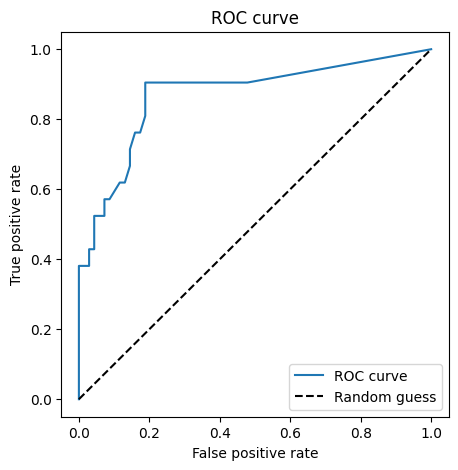

In [ ]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.show()

In [ ]:
pred_bin = [1 if i>optimal_thresh else 0 for i in pred ]

In [ ]:
cf_matrix = confusion_matrix(label, pred_bin)
print(classification_report(label, pred_bin))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93        69
           1       0.73      0.90      0.81        21

    accuracy                           0.90        90
   macro avg       0.85      0.90      0.87        90
weighted avg       0.91      0.90      0.90        90



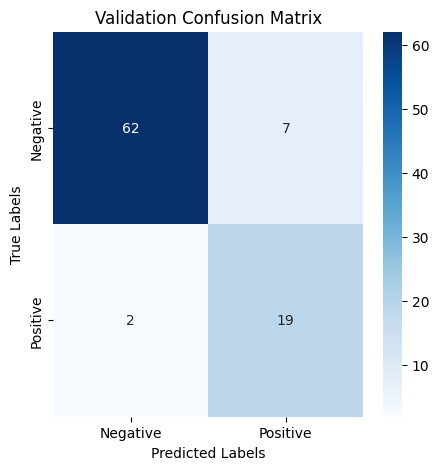

In [ ]:
plt.rcParams['figure.figsize'] = [5,5] # width, height
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=["Negative","Positive"], yticklabels=["Negative","Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Validation Confusion Matrix")
plt.show()

## Results on Test Set

In [ ]:
# Prediction on the whole test set

test_ad = list(set([i.split('___')[0] for i in os.listdir('test/AD')]))
test_hc = list(set([i.split('___')[0] for i in os.listdir('test/HC')]))

pred = []
label = []
for i in tqdm(test_ad):
  current_pred=[]
  for j in range(105):
    img = cv2.imread(f'test/AD/{i}____{j}.png',0)
    f=np.expand_dims(np.expand_dims(cv2.resize(img,(128,128), interpolation=cv2.INTER_LINEAR), 0),3)
    current_pred.append(np.argmin(net.predict(f, verbose=0)))

  pred.append(sum(current_pred)/len(current_pred))

  label.append(1)

for i in tqdm(test_hc):
  current_pred=[]
  for j in range(105):
    img = cv2.imread(f'test/HC/{i}____{j}.png',0)
    f=np.expand_dims(np.expand_dims(cv2.resize(img,(128,128), interpolation=cv2.INTER_LINEAR), 0),3)
    current_pred.append(np.argmin(net.predict(f, verbose=0)))

  pred.append(sum(current_pred)/len(current_pred))
  label.append(0)

100%|██████████| 69/69 [06:48<00:00,  5.91s/it]


In [ ]:
# Using the treshold decided on validation set
pred_bin = [1 if i>optimal_thresh else 0 for i in pred ]

In [ ]:
cf_matrix = confusion_matrix(label, pred_bin)
print(classification_report(label, pred_bin))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96        69
           1       0.90      0.86      0.88        21

    accuracy                           0.94        90
   macro avg       0.93      0.91      0.92        90
weighted avg       0.94      0.94      0.94        90



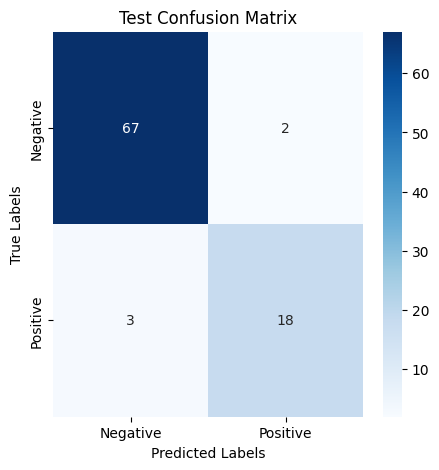

In [ ]:
plt.rcParams['figure.figsize'] = [5,5]
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=["Negative","Positive"], yticklabels=["Negative","Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Test Confusion Matrix")
plt.show()